# Analysis & *.h5 saving of cells and backgrounds
### Johanna Rahm, Sebastian Malkusch
#### Research group Heilemann
#### Institute for Physical and Theoretical Chemistry, Goethe University Frankfurt a.M.
This notebook as to be reloaded before analysing a new group of data!

## Load the trajectory files

Choose/insert a directory for the cell files to be searched in (e.g. F:\Marburg\single_colour_tracking\resting). All *.tracked.csv, *tracked.txt or *.trc  files in the directory will be loaded for the analysis, depending on the chosen software. It is possible to ignore files, by choosing mask words. If a file name containes any mask word, it will not be loaded. Comma separate multiple mask words (e.g. hmm, background, cell02).

In [1]:
from pySPT.widgets.widgetNotebooks import init_save_track_analysis
from pySPT.widgets import hdf5
from pySPT.widgets import widgetTrackAnalysis
from pySPT.widgets import widgetColumnSort
from pySPT.widgets import widgetDirectoryStructure
from pySPT.Analysis import coverSlip
from pySPT.Analysis import trackAnalysis
from pySPT.Analysis import trcFormat
from tqdm import tqdm_notebook as tqdm
import warnings
widget_track_analysis = widgetTrackAnalysis.WidgetTrackAnalysis()
track_analysis = trackAnalysis.TrackAnalysis()
cover_slip = coverSlip.CoverSlip()
display(widget_track_analysis.software_button, widget_track_analysis.ignore_words_box, widget_track_analysis.dir_box, widget_track_analysis.dir_button)
widget_track_analysis.dir_button.on_click(widget_track_analysis.open_dir)
widget_track_analysis.dir_box.observe(widget_track_analysis.change_dir_box)

RadioButtons(options=('ThunderSTORM', 'rapidSTORM', 'PALMTracer'), value='ThunderSTORM')

Text(value='', description='Mask words', placeholder='type something', style=DescriptionStyle(description_widt…

Text(value='', description='Directory', placeholder='directory to be searched in', style=DescriptionStyle(desc…

Button(description='browse', style=ButtonStyle(), tooltip='browse for directory')

Choose/insert the complete directory for the roi.log file which contains the cell sizes (e.g. F:\Marburg\single_colour_tracking\resting\roi.log). If no cell size was determined, the camera chip size will be set as the size. The file name of the cell with no .* ending is compared with the roi entries with no .* ending. The last fitting entry is taken as the cell size. 

In [2]:
display(widget_track_analysis.roi_box, widget_track_analysis.roi_button)
widget_track_analysis.roi_button.on_click(widget_track_analysis.open_roi)
widget_track_analysis.roi_box.observe(widget_track_analysis.change_roi_box)

Text(value='', description='roi', placeholder='path of roi', style=DescriptionStyle(description_width='initial…

Button(description='browse', style=ButtonStyle(), tooltip='browse for roi')

## Camera details

Based on the pixel size, the localization will be transfered from pixel to micrometer.
Based on the amount of pixel, the camera area will be calculated (e.g. 256 * 256=65536 pixel). Camera integration time is needed for MSD calculations.

In [3]:
display(widget_track_analysis.camera_pixel_size_box, widget_track_analysis.camera_pixel_amount_box, widget_track_analysis.camera_integration_time_box)

Text(value='158', description='Pixel size [nm]', placeholder='Type something', style=DescriptionStyle(descript…

Text(value='65536', description='Amount of pixel on the camera', placeholder='Type something', style=Descripti…

Text(value='0.02', description='Camera integration time [s]', placeholder='Type something', style=DescriptionS…

## Parameters for Diffusion Type Analysis

The degree of freedom of the diffusion coefficient D is inserted in the calculation of D (1D = 2, 2D = 4, 3D = 6 dof). The minimal detectable diffusion coefficient is the threshold for the immobile type analysis.
Based on the formular min_track_length * camera_integration_time = n -> tau_threshold = 0.3*n, the tau threshold for diffusion type determination free & confined is set.

In [4]:
display(widget_track_analysis.points_D_fit_box, widget_track_analysis.rossier_fit_area_box, widget_track_analysis.dof_box, widget_track_analysis.D_min_box, widget_track_analysis.min_track_length_box)

Text(value='4', description='Number of points fitted for D', placeholder='Type something', style=DescriptionSt…

Text(value='0.6', description='Fit area Rossier', placeholder='Type something', style=DescriptionStyle(descrip…

Text(value='4', description='Degree of freedom of D', placeholder='Type something', style=DescriptionStyle(des…

Text(value='0.0038', description='Minimal detectable D  [μm²/s]', placeholder='Type something', style=Descript…

Text(value='20', description='Min track length', placeholder='Type something', style=DescriptionStyle(descript…

The diffusion type analysis can be based on the track id or seg id of a trajectory. A trajectory can contain multiple segmentations with different diffusion models that will be averaged. Therefore running the analysis on a segment level is recommended. For PALMTracer .trc files no seg id is available and the track id has to be chosen.

In [5]:
display(widget_track_analysis.trajectory_id_button)

RadioButtons(options=('seg id', 'track id'), value='seg id')

## Parameters for Hidden Markov Modeling

Check the box to prepare files for hidden markov modeling. A .trc file for the ermine cluster will be saved in the SPTAnalyser/hmm folder. Hidden markov modeling is applied to the track id to observe state transformations. Choose a min track length to investigate the system (at least number of points fitted for D + 1).

In [6]:
display(widget_track_analysis.hmm_check_box, widget_track_analysis.microscope_check_box, widget_track_analysis.min_track_length_hmm_box, widget_track_analysis.hmm_trc_float_precision_box)

Checkbox(value=True, description='Save .trc file')

Checkbox(value=True, description='Save .microscope file')

Text(value='20', description='Min track length', placeholder='Type something', style=DescriptionStyle(descript…

Text(value='10', description='Trc float precision', placeholder='Type something', style=DescriptionStyle(descr…

## Run Analysis

In [7]:
widget_dir_structure = widgetDirectoryStructure.WidgetDirStructure()#??
warnings.filterwarnings('ignore')
display(widget_track_analysis.run_button)
def run_analysis(event):
    widget_track_analysis.create_clear_output()
    widget_track_analysis.searchSubFolders(widget_track_analysis.dir_name)
    if widget_track_analysis.got_dir:
        cover_slip.rossier_fit_area, cover_slip.software, cover_slip.min_track_length_type, cover_slip.min_track_length_hmm, cover_slip.dt, cover_slip.pixel_size, cover_slip.pixel_amount, cover_slip.dof, cover_slip.D_min, cover_slip.roi_file, cover_slip.cell_files, cover_slip.points_fit_D, cover_slip.seg_id = widget_track_analysis.rossier_fit_area_box.value, widget_track_analysis.software_button.value, widget_track_analysis.min_track_length_box.value, widget_track_analysis.min_track_length_hmm_box.value, widget_track_analysis.camera_integration_time_box.value, widget_track_analysis.camera_pixel_size_box.value, widget_track_analysis.camera_pixel_amount_box.value, widget_track_analysis.dof_box.value, widget_track_analysis.D_min_box.value, widget_track_analysis.roi_name, widget_track_analysis.file_names, widget_track_analysis.points_D_fit_box.value, widget_track_analysis.trajectory_id_button.value      
        for cell_idx in range(len(cover_slip.cell_files)):
            if widget_track_analysis.software_button.value != "PALMTracer":
                if widget_track_analysis.software_button.value == "ThunderSTORM":
                    widget_column_sort = widgetColumnSort.WidgetColumnSort(cover_slip.cell_files[cell_idx], widget_track_analysis.software_button.value, ['"track.id"' , '"x [nm]"', '"y [nm]"', '"frame"', '"intensity [photon]"', '"seg.id"'])
                elif widget_track_analysis.software_button.value == "rapidSTORM":
                    widget_column_sort = widgetColumnSort.WidgetColumnSort(cover_slip.cell_files[cell_idx], widget_track_analysis.software_button.value, ['"track.id"', '"Position-0-0"', '"Position-1-0"', '"Amplitude-0-0"', '"ImageNumber-0-0"', '"seg.id"'])
                widget_column_sort.check_header()
                if widget_column_sort.correct_header:
                    widget_column_sort.run_column_sort()
                    cover_slip.column_orders.append(widget_column_sort.column_order)
        cover_slip.create_cells()  
        track_analysis.cell_sizes = [cell.size for cell in cover_slip.cells]
        track_analysis.cell_trajectories = cover_slip.cell_trajectories
        track_analysis.run_statistics_no_filter()
    else:
        widget_track_analysis.warning_trc_file()
    widget_track_analysis.cells = cover_slip.cells
widget_track_analysis.run_button.on_click(run_analysis)


Analysis took 10.568748712539673 s
 
21.33 % are immobile, mean D = -0.00021 μm²/s, mean length = 64 frames
13.11 % are confined, mean D = 0.07709 μm²/s, mean length = 34 frames
62.67 % are free, mean D = 0.08155 μm²/s, mean length = 60 frames
2.89 % could not be analysed, mean D = 0.00837 μm²/s, mean length = 37 frames
Total trajectories: 450


## Plot diffusion histogram

Plot the normalized frequency in % against the diffusion coefficients (log bins). Diffusion coefficients <= 0 are neglected, because the logarithm is not defined in this interval.

In [8]:
display(widget_track_analysis.bin_size_box)

Text(value='0.1', description='bin size', placeholder='size for log10(D) histogram', style=DescriptionStyle(de…

In [9]:
def plot_diffusions(event):
    widget_track_analysis.create_clear_output()
    display(widget_track_analysis.plot_diff_button)
    track_analysis.run_plot_diffusion_histogram(widget_track_analysis.bin_size_box.value)
display(widget_track_analysis.plot_diff_button)
widget_track_analysis.plot_diff_button.on_click(plot_diffusions)

Button(description='plot', style=ButtonStyle(), tooltip='plot diffusion histogram')

## Choose trajectory to plot

Choose a cell.

In [10]:
def dropdown(event):
    widget_track_analysis.cell_options = widget_track_analysis.get_cell_names(cover_slip.cells)
widget_track_analysis.run_button.on_click(dropdown)
display(widget_track_analysis.drop_down_cells)

Dropdown(description='Number:', options=(), value=None)

Choose a trajectory.

In [11]:
def dropdown(event):      
    for cell in cover_slip.cells:
        if cell.name == widget_track_analysis.drop_down_cells.value:
            target_cell = cover_slip.cells.index(cell)
            #trajectory_indexes = [i+1 for i, _ in enumerate(cover_slip.cell_trajectories[target_cell])]
            #if widget_track_analysis.trajectory_id_button.value == "seg id":
            #    idx = 6
            #elif widget_track_analysis.trajectory_id_button.value == "track id":
            #    idx = 0
            trajectory_indexes = [int(trajectory.trajectory_number) for trajectory in cell.analysed_trajectories]
            widget_track_analysis.trajectory_options = trajectory_indexes
            widget_track_analysis.drop_down_trajectories.options = widget_track_analysis.trajectory_options
widget_track_analysis.drop_down_cells.observe(dropdown)
display(widget_track_analysis.drop_down_trajectories)

Dropdown(description='Number:', options=(), value=None)

Button(description='plot', style=ButtonStyle(), tooltip='plot chosen trajectory')

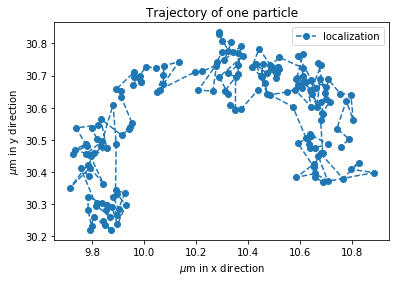

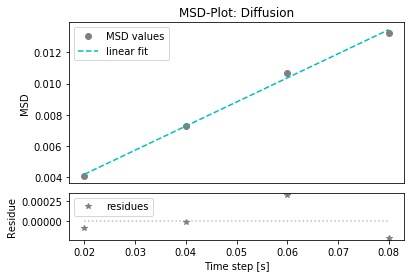

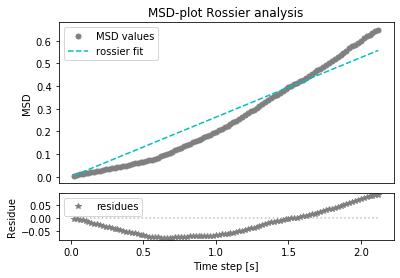

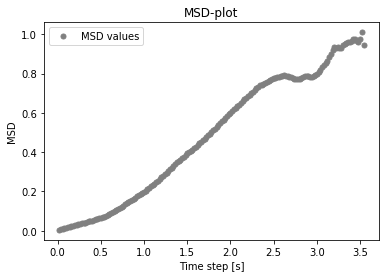

Number: 0
Trajectory length: 178
Diffusion coefficient: 0.03859115832723353 μm²/s
MSD0: 0.001102807712517499 μm²
chi² linear fit: 1.6088450617026307e-05 μm⁴
Type immobile: False
Analyse successful? True
chi² rossier fit: 1.366162709376914 μm⁴
Type confined: False
Type free: True
D_conf: 0.06574545474565027 μm²/s
r_conf: 111.55169343546444 μm
tau: 63090.700117400505 s
tau threshold: 0.12 s


In [12]:
def plot_particle(event):
    widget_track_analysis.create_clear_output()
    display(widget_track_analysis.plot_button)
    cover_slip.plot_trajectory(widget_track_analysis.drop_down_cells.value, widget_track_analysis.drop_down_trajectories.value)
display(widget_track_analysis.plot_button)
widget_track_analysis.plot_button.on_click(plot_particle)

## Save

For each cell a .h5 file will be created, containing all information of the trajectories (unfiltered).

In [13]:
def save_analysis(event):    
    for cell_index in tqdm(range(0, len(cover_slip.cells))):
        init_save_track_analysis(cover_slip, cell_index, track_analysis, widget_track_analysis)
display(widget_track_analysis.save_button)
widget_track_analysis.save_button.on_click(save_analysis)

Button(description='save', style=ButtonStyle(), tooltip='save entire analysis')